In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18
import os
from scipy.signal import medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.constants import c
c= c*1e-3 #in km/s
import os
import random

# MgII doublet values
from linetools.lists.linelist import LineList
linelist = LineList('ISM', verbose=False)
line1 = linelist['MgII 2796']
mg1 = line1['wrest'].value
line2 = linelist['MgII 2803']
mg2 = line2['wrest'].value
print(f"Mg_II first doublet = {mg1}\n" f"Mg_II second doublet = {mg2}\n" f"speed of light in vacuum in km/s = {c}")

read_sets: Using set file -- 
  /home/mehak-gupta/jupyter-venv/lib/python3.12/site-packages/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Mg_II first doublet = 2796.3543
Mg_II second doublet = 2803.5315
speed of light in vacuum in km/s = 299792.458


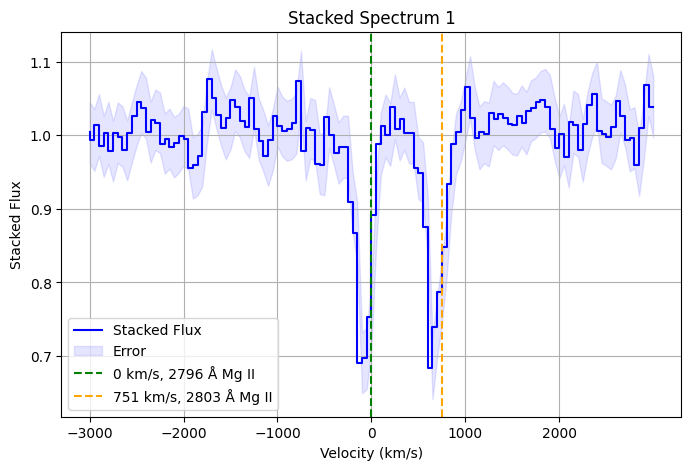

/tmp/ipykernel_17979/730380035.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew_vel = np.trapz(1 - f, v)


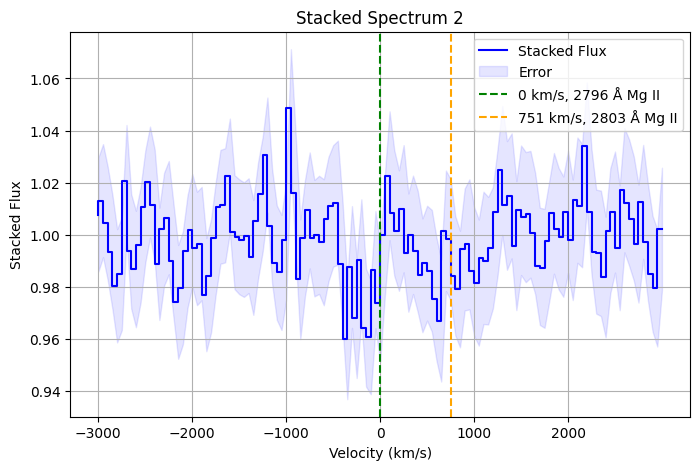

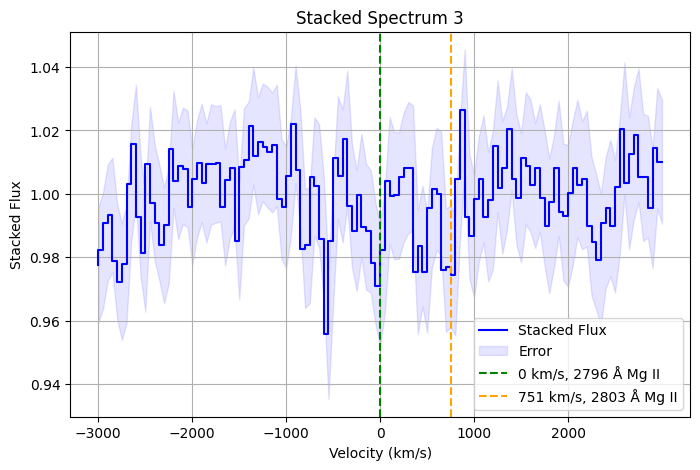

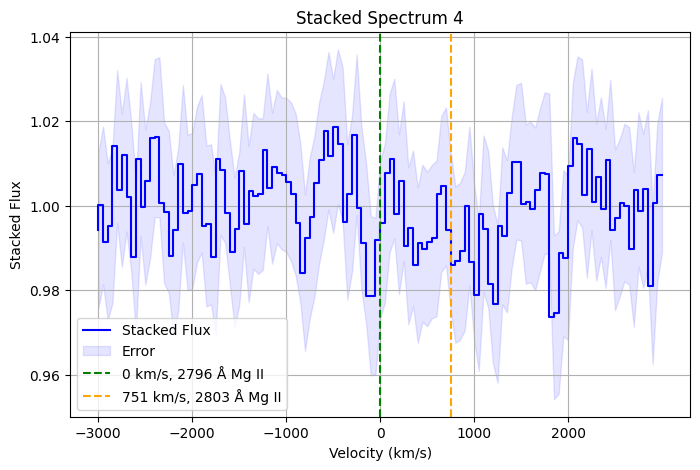

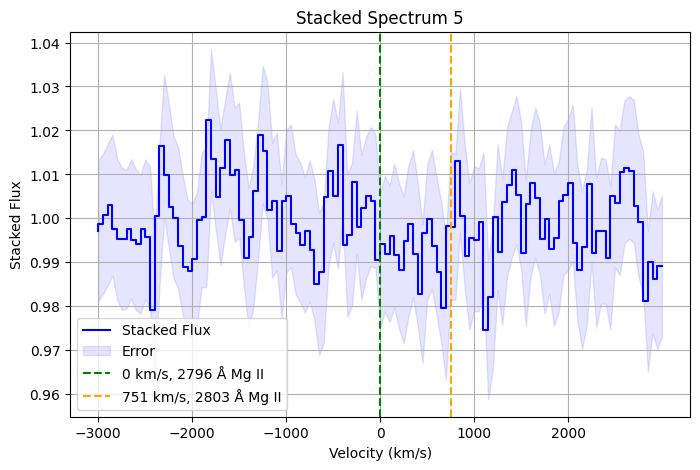

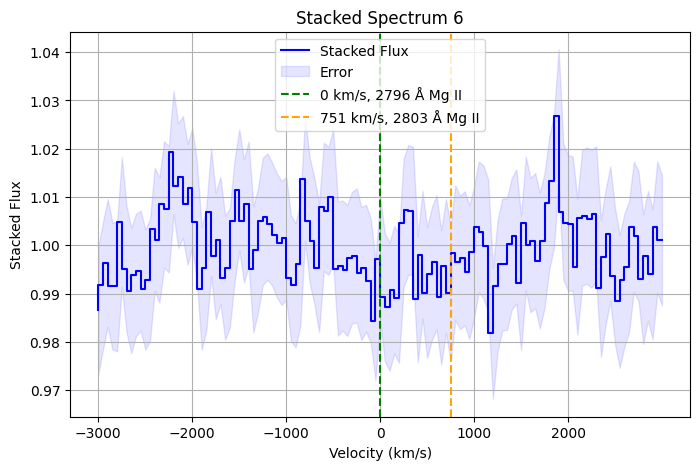

Index	SNR	EW_int(Å)	EW_err(Å)	EW_lim(Å)	Detection	R(kpc)	Range
1	23.29	0.57	0.07	0.22	Detect	15	0–30
2	42.60	0.08	-	0.12	Limit	45	30–60
3	50.61	0.03	-	0.10	Limit	75	60–90
4	53.29	0.00	-	0.09	Limit	105	90–120
5	61.87	0.00	-	0.08	Limit	135	120–150
6	74.14	0.04	-	0.07	Limit	165	150–180


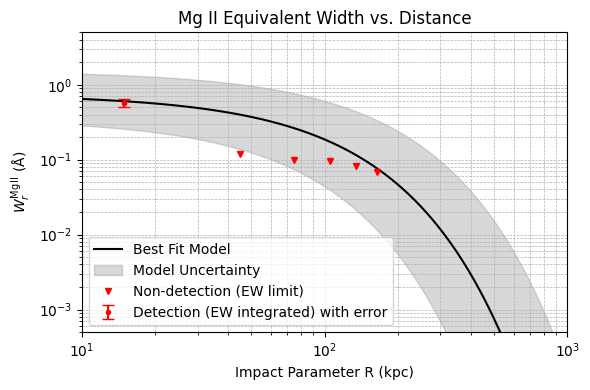

In [39]:
# Metal-enriched halo gas across galaxy overdensities over the last 10 billion years 
#by Rajeshwari Dutta et al Advance Access publication 2021 September 25
	
# Constants and params
vpix = 50  # velocity resolution per pixel in km/s
n_sigma = 3
lambda_0 = mg1  # line center (2796 Å)
velocity_range = (-450, 200)  # region to assess SNR (km/s)
impact_parameters = np.array([15, 45, 75, 105, 135, 165])  # kpc

stacked_dir = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /bg_sources/high_sm_high_sfr/velocity/stacked/"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/final/"
os.makedirs(pic_dir, exist_ok=True)

all_data = []

# To store results
snr_values = []
equivalent_widths_int = []  # integrated EW (from data)
equivalent_widths_lim = []  # EW limits (from noise)
equivalent_widths_err = []  # propagated error on integrated EW
detection_flags = []  # True if detection, else False

c = 3e5  # speed of light km/s

for i in range(1, 7):
    file_path = os.path.join(stacked_dir, f"median_stacked_spectrum{i}.txt")
    data = np.loadtxt(file_path, skiprows=1)

    velocity, stacked_flux, stacked_error = data[:, 0], data[:, 1], data[:, 2]
    all_data.append(np.column_stack((velocity, stacked_flux, stacked_error)))

    # Plot spectrum
    plt.figure(figsize=(8, 5))
    plt.step(velocity, stacked_flux, color='blue', label="Stacked Flux")
    plt.fill_between(velocity, stacked_flux - stacked_error, stacked_flux + stacked_error,
                     color='blue', alpha=0.1, label="Error")
    plt.axvline(x=0, color='green', lw=1.5, linestyle="--", label="0 km/s, 2796 Å Mg II")
    plt.axvline(x=751, color='orange', lw=1.5, linestyle="--", label="751 km/s, 2803 Å Mg II")
    plt.xlabel("Velocity (km/s)")
    plt.ylabel("Stacked Flux")
    plt.xticks(np.arange(-3000, 3000, 1000))
    plt.title(f"Stacked Spectrum {i}")
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig(os.path.join(pic_dir, f"stacked{i}_vel_snr3.png"), dpi=300, bbox_inches="tight")
    #plt.close()

    # Calculate integrated EW and limit
    mask = (velocity >= velocity_range[0]) & (velocity <= velocity_range[1])
    v = velocity[mask]
    f = stacked_flux[mask]
    err = stacked_error[mask]

    snr = np.median(f / err)
    snr_values.append(snr)

    # Integrated equivalent width (in velocity units)
    ew_vel = np.trapz(1 - f, v)
    ew_ang = ew_vel * lambda_0 / c

    # Propagated error on EW from error in flux
    dv = np.median(np.diff(v))
    ew_err_vel = np.sqrt(np.sum((err * dv)**2))
    ew_err_ang = ew_err_vel * lambda_0 / c

    # Equivalent width limit
    npix = 13  # fixed window of ~650 km/s (~13 pixels × 50 km/s)
    ew_limit = n_sigma * lambda_0 * vpix * np.sqrt(npix) / (snr * c)

    equivalent_widths_int.append(ew_ang)
    equivalent_widths_lim.append(ew_limit)
    equivalent_widths_err.append(ew_err_ang)

    detection_flags.append(ew_ang > ew_limit)

# Prepare for table output and plotting
impact_bins = ["0–30", "30–60", "60–90", "90–120", "120–150", "150–180"]

print("Index\tSNR\tEW_int(Å)\tEW_err(Å)\tEW_lim(Å)\tDetection\tR(kpc)\tRange")
for i in range(len(impact_parameters)):
    det = "Detect" if detection_flags[i] else "Limit"
    ew_err_str = f"{equivalent_widths_err[i]:.2f}" if detection_flags[i] else "-"
    print(f"{i+1}\t{snr_values[i]:.2f}\t{equivalent_widths_int[i]:.2f}\t{ew_err_str}\t{equivalent_widths_lim[i]:.2f}\t{det}\t{impact_parameters[i]}\t{impact_bins[i]}")

# Separate detections and limits for plotting
det_impact = [impact_parameters[i] for i in range(len(impact_parameters)) if detection_flags[i]]
det_wr = [equivalent_widths_int[i] for i in range(len(impact_parameters)) if detection_flags[i]]
det_err = [equivalent_widths_err[i] for i in range(len(impact_parameters)) if detection_flags[i]]

limit_impact = [impact_parameters[i] for i in range(len(impact_parameters)) if not detection_flags[i]]
limit_wr = [equivalent_widths_lim[i] for i in range(len(impact_parameters)) if not detection_flags[i]]

# Model fit and uncertainty envelope (same as original)
R = np.logspace(1, 3, 500)  # 10 to 1000 kpc
a, b = -0.13, -0.006
a_err_up, a_err_down = 0.31, 0.33
b_err_up, b_err_down = 0.002, 0.003

logW_1 = (a + a_err_up) + (b + b_err_up) * R
logW_2 = (a + a_err_up) + (b - b_err_down) * R
logW_3 = (a - a_err_down) + (b + b_err_up) * R
logW_4 = (a - a_err_down) + (b - b_err_down) * R

logW_stack = np.vstack([logW_1, logW_2, logW_3, logW_4])
logW_upper = np.max(logW_stack, axis=0)
logW_lower = np.min(logW_stack, axis=0)
logW_central = a + b * R

W_upper = 10**logW_upper
W_lower = 10**logW_lower
W_central = 10**logW_central

# Plot everything
plt.figure(figsize=(6,4))
plt.plot(R, W_central, color='black', label='Best Fit Model')
plt.fill_between(R, W_lower, W_upper, color='gray', alpha=0.3, label='Model Uncertainty')
plt.errorbar(det_impact, det_wr, yerr=det_err, fmt='o', color='red', markersize=3, capsize=4, label="Detection (EW integrated) with error")
plt.plot(limit_impact, limit_wr, 'v', color='red', markersize=4, label="Non-detection (EW limit)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Impact Parameter R (kpc)')
plt.ylabel(r'$W_r^{\mathrm{Mg\,II}}$ (Å)')
plt.title('Mg II Equivalent Width vs. Distance')
plt.xlim(10, 1000)
plt.ylim(5e-4, 5)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(pic_dir, "Eq_width1.png"), dpi=300, bbox_inches="tight")
plt.show()


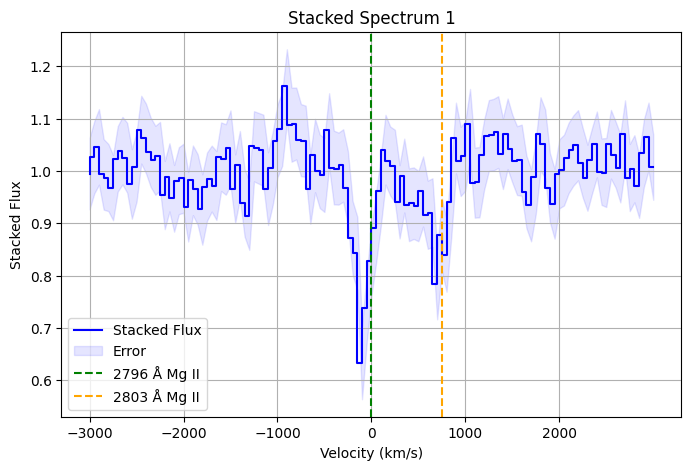

/tmp/ipykernel_17979/2444285533.py:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew_vel = np.trapz(1 - f, v)


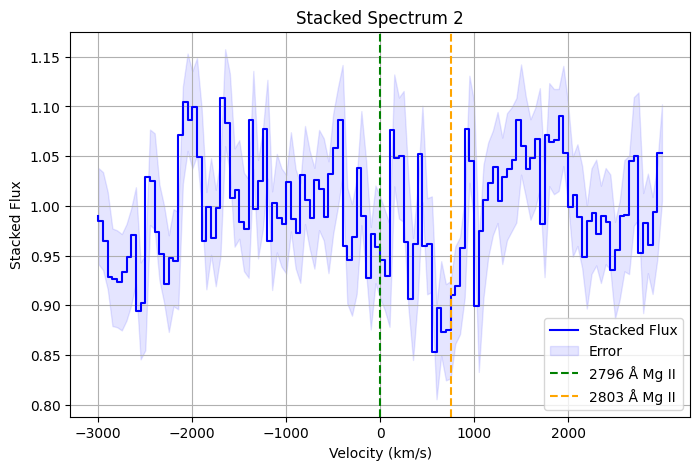

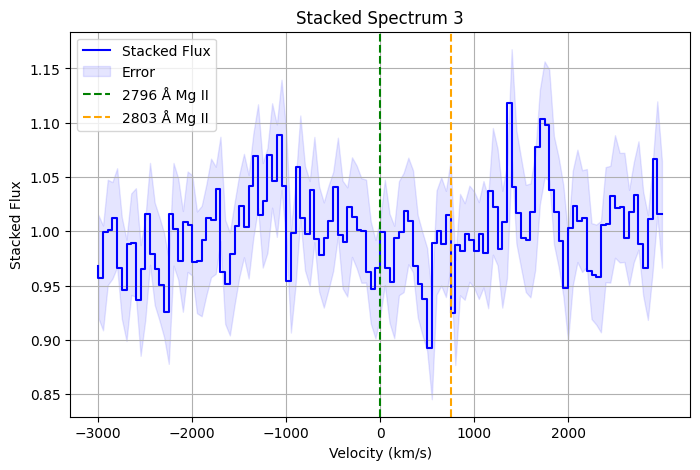

Index	SNR	EW(Å)	±Error	EW_limit(Å)	Type	Impact(kpc)
1	13.77	1.02	±0.16	0.50	detect	25.0
2	18.03	0.44	±0.12	0.38	detect	57.5
3	20.57	0.23	±0.11	0.33	limit	72.5

--- Paper Comparison ---
Impact: 25.0 kpc	Paper EW: 0.88 ± 0.07 Å
Impact: 57.5 kpc	Paper EW: 0.32 ± 0.05 Å
Impact: 72.5 kpc	Paper EW: 0.11 ± 0.04 Å


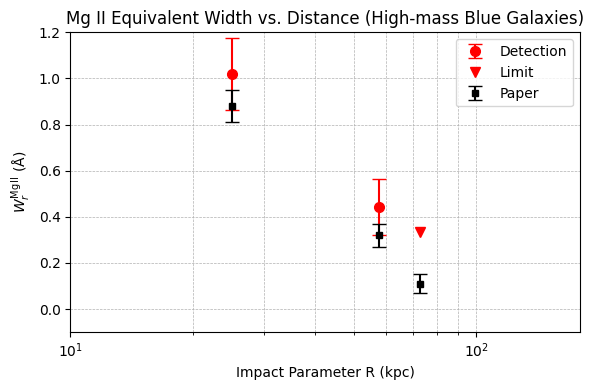

In [40]:
# Comparing with THE RADIAL AND AZIMUTHAL PROFILES OF Mg II ABSORPTION AROUND 0.5 < z < 0.9 zCOSMOS GALAXIES OF DIFFERENT COLORS, MASSES AND ENVIRONMENTS+
# high sfr (blue galaxies) and stellar mass >= 9.88 solar mass

# --- Constants ---
c = 3e5  # speed of light in km/s
mg1 = 2796.0  # central wavelength for Mg II 2796
lambda_0 = mg1

# --- Configuration ---
vpix = 50  # velocity resolution per pixel in km/s
n_sigma = 3
velocity_range = (-300, 850)  # in km/s
impact_parameters = np.array([25, 57.5, 72.5])  # in kpc

# --- File paths ---
stacked_dir = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /bg_sources/blue_galaxies/high_mass/velocity/stacked/"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/final/"
os.makedirs(pic_dir, exist_ok=True)

# --- Storage ---
all_data = []
results = []

# --- Loop over spectra ---
for i in range(1, 4):
    file_path = os.path.join(stacked_dir, f"median_stacked_spectrum{i}.txt")
    data = np.loadtxt(file_path, skiprows=1)

    velocity, stacked_flux, stacked_error = data[:, 0], data[:, 1], data[:, 2]
    all_data.append(np.column_stack((velocity, stacked_flux, stacked_error)))

    # Plot each stacked spectrum
    plt.figure(figsize=(8, 5))
    plt.step(velocity, stacked_flux, color='blue', label="Stacked Flux")
    plt.fill_between(velocity, stacked_flux - stacked_error, stacked_flux + stacked_error,
                     color='blue', alpha=0.1, label="Error")
    plt.axvline(x=0, color='green', lw=1.5, linestyle="--", label="2796 Å Mg II")
    plt.axvline(x=751, color='orange', lw=1.5, linestyle="--", label="2803 Å Mg II")
    plt.xlabel("Velocity (km/s)")
    plt.ylabel("Stacked Flux")
    plt.xticks(np.arange(-3000, 3000, 1000))
    plt.title(f"Stacked Spectrum {i}")
    plt.legend()
    plt.grid()
    plt.show()

    # --- EW + SNR + Limit Calculations ---
    mask = (velocity >= velocity_range[0]) & (velocity <= velocity_range[1])
    v = velocity[mask]
    f = stacked_flux[mask]
    err = stacked_error[mask]

    snr = np.median(f / err)

    # Integrated EW
    ew_vel = np.trapz(1 - f, v)
    ew_ang = ew_vel * lambda_0 / c

    # Error propagation
    delta_v = v[1] - v[0]
    ew_err_vel = np.sqrt(np.sum(err**2)) * delta_v
    ew_err_ang = ew_err_vel * lambda_0 / c

    # EW limit
    npix = len(v)
    wr_limit = n_sigma * lambda_0 * vpix * np.sqrt(npix) / (snr * c)

    if ew_ang > wr_limit:
        detection = 'detect'
        wr_plot = ew_ang
        marker = 'o'
        ew_err_plot = ew_err_ang
    else:
        detection = 'limit'
        wr_plot = wr_limit
        marker = 'v'
        ew_err_plot = 0

    results.append({
        "index": i,
        "snr": snr,
        "ew": ew_ang,
        "ew_err": ew_err_ang,
        "wr_limit": wr_limit,
        "type": detection,
        "impact": impact_parameters[i-1],
        "plot_val": wr_plot,
        "marker": marker,
        "err_plot": ew_err_plot
    })

# --- Paper Data ---
paper_wr = [0.88, 0.32, 0.11]
paper_err = [0.07, 0.05, 0.04]

# --- Output Table ---
print("Index\tSNR\tEW(Å)\t±Error\tEW_limit(Å)\tType\tImpact(kpc)")
for r in results:
    print(f"{r['index']}\t{r['snr']:.2f}\t{r['ew']:.2f}\t±{r['ew_err']:.2f}\t{r['wr_limit']:.2f}\t{r['type']}\t{r['impact']}")

print("\n--- Paper Comparison ---")
for i in range(3):
    print(f"Impact: {impact_parameters[i]} kpc\tPaper EW: {paper_wr[i]:.2f} ± {paper_err[i]:.2f} Å")

# --- Plotting ---
plt.figure(figsize=(6, 4))

for r in results:
    plt.errorbar(r["impact"], r["plot_val"], yerr=r["err_plot"] if r["type"] == "detect" else None,
                 fmt=r["marker"], color='red',
                 label="Detection" if r["type"] == "detect" else "Limit",
                 markersize=7, capsize=5)

# Add paper data
plt.errorbar(impact_parameters, paper_wr, yerr=paper_err, fmt='s', color='black',
             label='Paper', markersize=5, capsize=5)

# Remove duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xscale('log')
plt.xlabel('Impact Parameter R (kpc)')
plt.ylabel(r'$W_r^{\mathrm{Mg\,II}}$ (Å)')
plt.title('Mg II Equivalent Width vs. Distance (High-mass Blue Galaxies)')
plt.xlim(10, 180)
plt.ylim(-0.1, 1.2)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(pic_dir, "Eq_width2.png"), dpi=300, bbox_inches="tight")
plt.show()


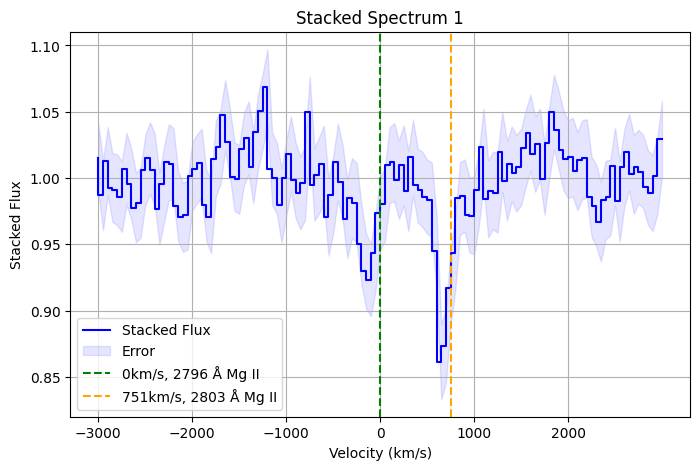

/tmp/ipykernel_17979/2937028310.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew_vel = np.trapz(1 - f, v)


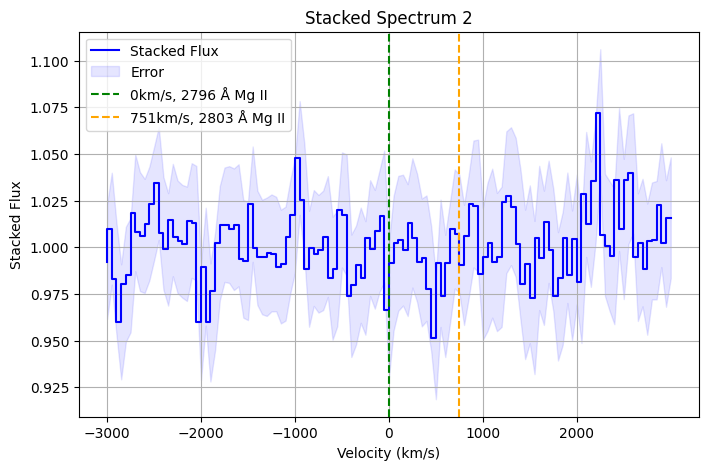

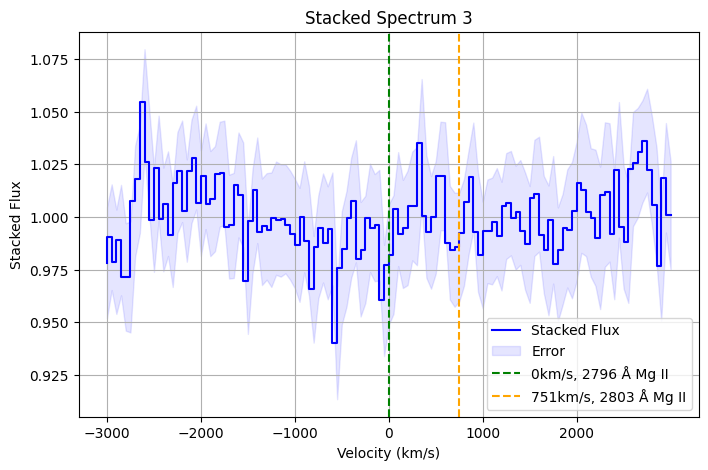

Index	SNR	EW(Å)	±Error	EW_limit(Å)	Type	Impact(kpc)
1	33.89	0.43	±0.07	0.23	detect	25.0
2	29.59	0.06	±0.09	0.26	limit	57.5
3	37.14	0.05	±0.07	0.21	limit	72.5

--- Paper Comparison ---
Impact: 25.0 kpc	Paper EW: 0.50 ± 0.08 Å
Impact: 57.5 kpc	Paper EW: 0.26 ± 0.06 Å
Impact: 72.5 kpc	Paper EW: 0.12 ± 0.08 Å


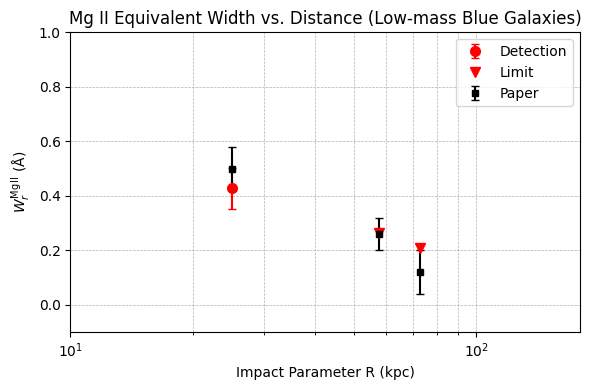

In [41]:
# Comparing with THE RADIAL AND AZIMUTHAL PROFILES OF Mg II ABSORPTION AROUND 0.5 < z < 0.9 zCOSMOS GALAXIES OF DIFFERENT COLORS, MASSES AND ENVIRONMENTS+
# high sfr (blue galaxies) and stellar mass < 9.88 solar mass

# --- Physical Constants ---
c = 3e5  # speed of light in km/s
mg1 = 2796.0  # central wavelength for Mg II 2796 line in Å
lambda_0 = mg1

# --- Configuration ---
vpix = 50  # velocity resolution per pixel in km/s
n_sigma = 3
velocity_range = (-450, 1050)
impact_parameters = np.array([25, 57.5, 72.5])  # kpc

stacked_dir = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /bg_sources/blue_galaxies/low_mass/velocity/stacked/"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/final/"
os.makedirs(pic_dir, exist_ok=True)

# --- Data holders ---
results = []

# --- Process each spectrum ---
for i in range(1, 4):
    file_path = os.path.join(stacked_dir, f"median_stacked_spectrum{i}.txt")
    data = np.loadtxt(file_path, skiprows=1)
    velocity, stacked_flux, stacked_error = data[:, 0], data[:, 1], data[:, 2]

    # Plot spectrum
    plt.figure(figsize=(8, 5))
    plt.step(velocity, stacked_flux, color='blue', label="Stacked Flux")
    plt.fill_between(velocity, stacked_flux - stacked_error, stacked_flux + stacked_error, 
                     color='blue', alpha=0.1, label="Error")
    plt.axvline(x=0, color='green', lw=1.5, linestyle="--", label="0km/s, 2796 Å Mg II")
    plt.axvline(x=751, color='orange', lw=1.5, linestyle="--", label="751km/s, 2803 Å Mg II")
    plt.xlabel("Velocity (km/s)")
    plt.ylabel("Stacked Flux")
    plt.xticks(np.arange(-3000, 3000, 1000))
    plt.title(f"Stacked Spectrum {i}")
    plt.legend()
    plt.grid()
    plt.show()

    # ----- EW + SNR + Limit Calculations -----
    mask = (velocity >= velocity_range[0]) & (velocity <= velocity_range[1])
    v = velocity[mask]
    f = stacked_flux[mask]
    err = stacked_error[mask]

    snr = np.median(f / err)

    # --- Integrated EW ---
    ew_vel = np.trapz(1 - f, v)
    ew_ang = ew_vel * lambda_0 / c

    # --- Propagated Error on EW ---
    delta_v = v[1] - v[0]
    ew_err_vel = np.sqrt(np.sum(err**2)) * delta_v
    ew_err_ang = ew_err_vel * lambda_0 / c

    # --- EW Limit ---
    npix = len(v)
    wr_limit = n_sigma * lambda_0 * vpix * np.sqrt(npix) / (snr * c)

    # --- Detection or Limit ---
    if ew_ang > wr_limit:
        detection = 'detect'
        plot_val = ew_ang
        err_plot = ew_err_ang
        marker = 'o'
        color = 'red'
    else:
        detection = 'limit'
        plot_val = wr_limit
        err_plot = 0
        marker = 'v'
        color = 'red'

    results.append({
        "index": i,
        "snr": snr,
        "ew": ew_ang,
        "ew_err": ew_err_ang,
        "wr_limit": wr_limit,
        "type": detection,
        "impact": impact_parameters[i-1],
        "plot_val": plot_val,
        "marker": marker,
        "color": color,
        "err_plot": err_plot
    })

# --- Paper Data ---
paper_wr = [0.50, 0.26, 0.12]
paper_err = [0.08, 0.06, 0.08]

# --- Print Observed Results ---
print("Index\tSNR\tEW(Å)\t±Error\tEW_limit(Å)\tType\tImpact(kpc)")
for r in results:
    print(f"{r['index']}\t{r['snr']:.2f}\t{r['ew']:.2f}\t±{r['ew_err']:.2f}\t{r['wr_limit']:.2f}\t{r['type']}\t{r['impact']}")

# --- Print Paper Results ---
print("\n--- Paper Comparison ---")
for i in range(3):
    print(f"Impact: {impact_parameters[i]} kpc\tPaper EW: {paper_wr[i]:.2f} ± {paper_err[i]:.2f} Å")

# --- Plot ---
plt.figure(figsize=(6, 4))
for r in results:
    plt.errorbar(r["impact"], r["plot_val"], yerr=r["err_plot"] if r["type"] == "detect" else None,
                 fmt=r["marker"], color=r["color"], markersize=7, capsize=3,
                 label="Detection" if r["type"] == "detect" else "Limit")

# Paper points
plt.errorbar(impact_parameters, paper_wr, yerr=paper_err, fmt='s', color='black', markersize=4,
             capsize=3, label='Paper')

# Unique legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xscale('log')
plt.xlabel('Impact Parameter R (kpc)')
plt.ylabel(r'$W_r^{\mathrm{Mg\,II}}$ (Å)')
plt.title('Mg II Equivalent Width vs. Distance (Low-mass Blue Galaxies)')
plt.xlim(10, 180)
plt.ylim(-0.1, 1.0)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(pic_dir, "Eq_width3.png"), dpi=300, bbox_inches="tight")
plt.show()


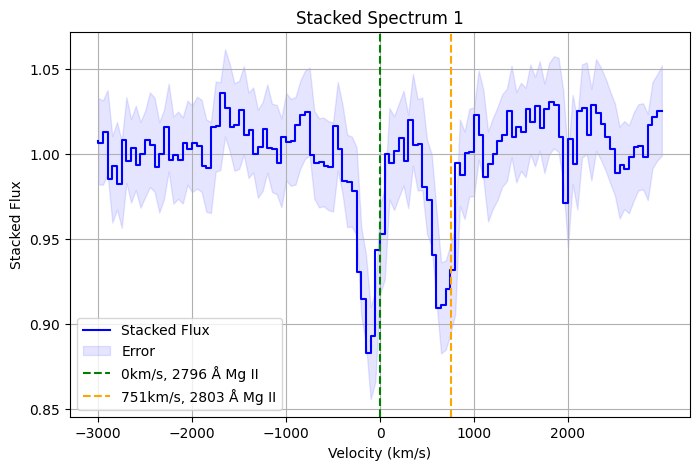

/tmp/ipykernel_17979/770680930.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew_vel = np.trapz(1 - f, v)


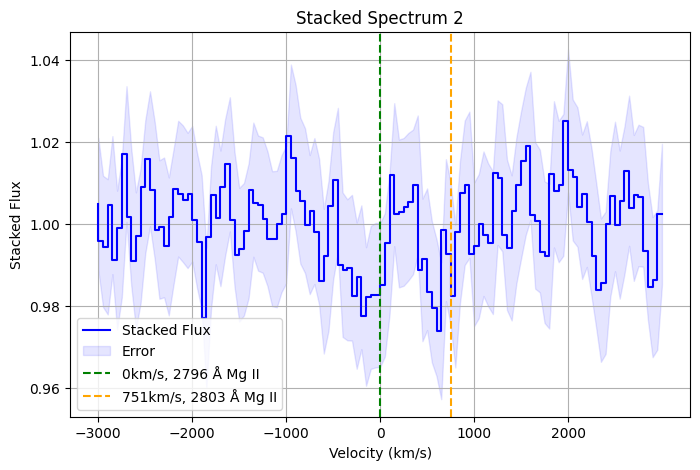

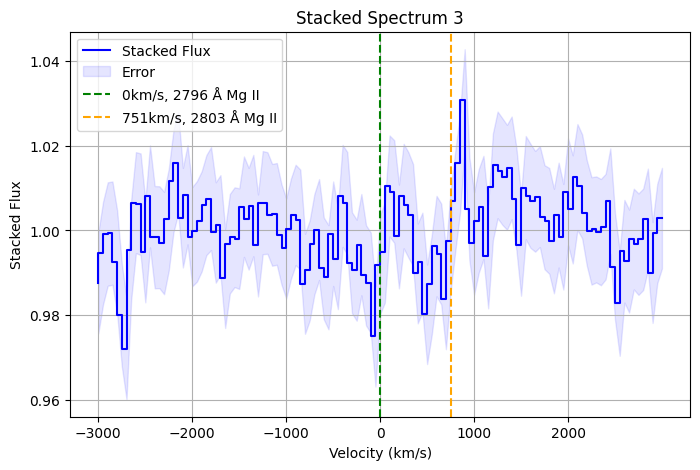

Index	SNR	EW(Å)	Type	R(kpc)	Range
1	36.20	0.25	detect	15	0–30
2	56.30	0.09	limit	40	30–50
3	83.33	0.06	limit	100	50-150


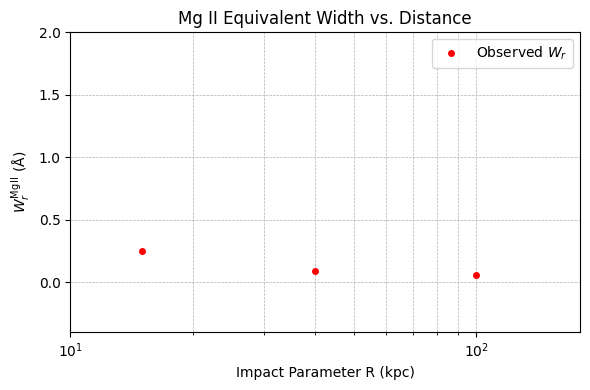

In [42]:
# Comparing with GALAXIES PROBING GALAXIES IN PRIMUS – I. SAMPLE, SPECTROSCOPY, AND CHARACTERISTICS
# OF THE z ∼ 0.5 MG II-ABSORBING CIRCUMGALACTIC MEDIUM
# Kate H. R. Rubin,1 Aleksandar M. Diamond-Stanic,2 Alison L. Coil,3 Neil H. M. Crighton,4 and John Moustakas5
# all galaxies

vpix = 50  # velocity resolution per pixel in km/s
n_sigma = 3
lambda_0 = mg1  # define your line center before running this
velocity_range = (-400, 200)  # region to assess SNR
impact_parameters = np.array([15,40,100])  # kpc

stacked_dir = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /bg_sources/medfilt_cont/velocity/stacked/"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/final/"
os.makedirs(pic_dir, exist_ok=True)

all_data = []
equivalent_widths = []
snr_values = []
wr_limits = []

for i in range(1, 4):
    file_path = os.path.join(stacked_dir, f"median_stacked_spectrum{i}.txt")
    data = np.loadtxt(file_path, skiprows=1)

    # Extract columns
    velocity, stacked_flux, stacked_error = data[:, 0], data[:, 1], data[:, 2]
    all_data.append(np.column_stack((velocity, stacked_flux, stacked_error)))

    # Plot spectrum
    plt.figure(figsize=(8, 5))
    plt.step(velocity, stacked_flux, color='blue', label="Stacked Flux")
    plt.fill_between(velocity, stacked_flux - stacked_error, stacked_flux + stacked_error, 
                     color='blue', alpha=0.1, label="Error")
    plt.axvline(x=0, color='green', lw=1.5, linestyle="--", label="0km/s, 2796 Å Mg II")
    plt.axvline(x=751, color='orange', lw=1.5, linestyle="--", label="751km/s, 2803 Å Mg II")
    plt.xlabel("Velocity (km/s)")
    plt.ylabel("Stacked Flux")
    plt.xticks(np.arange(-3000, 3000, 1000))
    plt.title(f"Stacked Spectrum {i}")
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig(os.path.join(pic_dir, f"stacked{i}_vel_snr3.png"), dpi=300, bbox_inches="tight")
    #plt.close()

    # ---------- EW or limit calculation ----------
    mask = (velocity >= velocity_range[0]) & (velocity <= velocity_range[1])
    v = velocity[mask]
    f = stacked_flux[mask]
    err = stacked_error[mask]

    snr = np.median(f / err)
    snr_values.append(snr)

    if np.min(f) < 1 - n_sigma * np.median(err):
        # Detection: calculate EW
        ew_vel = np.trapz(1 - f, v)
        ew_ang = ew_vel * lambda_0 / c
        equivalent_widths.append((ew_ang, 'detect'))
        wr_limits.append(None)
    else:
        # Non-detection: calculate EW limit
        npix = 12  # fixed window of ~600 km/s
        wr_limit = n_sigma * lambda_0 * vpix * np.sqrt(npix) / (snr * c)
        equivalent_widths.append((wr_limit, 'limit'))
        wr_limits.append(wr_limit)

# Define impact parameter bins
impact_bins = ["0–30", "30–50", "50-150"]

# Display EW results with SNR and impact parameter bin
print("Index\tSNR\tEW(Å)\tType\tR(kpc)\tRange")
observed_wr = []
observed_impact = []

for i, ((value, ew_type), snr) in enumerate(zip(equivalent_widths, snr_values)):
    impact = impact_parameters[i]
    bin_label = impact_bins[i] if i < len(impact_bins) else "N/A"
    print(f"{i+1}\t{snr:.2f}\t{value:.2f}\t{ew_type}\t{impact}\t{bin_label}")
    observed_wr.append(value)
    observed_impact.append(impact)
    

# Plot observed values + model and uncertainty
plt.figure(figsize=(6,4))
plt.plot(observed_impact, observed_wr, 'o', color='red', markersize=4, label="Observed $W_r$")
plt.xscale('log')
plt.xlabel('Impact Parameter R (kpc)')
plt.ylabel(r'$W_r^{\mathrm{Mg\,II}}$ (Å)')
plt.title('Mg II Equivalent Width vs. Distance')
plt.xlim(10, 180)
plt.ylim(-0.4,2.0)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


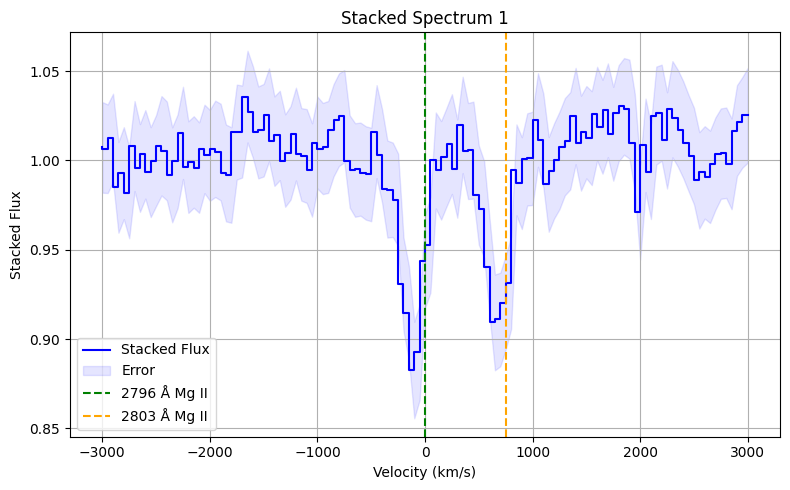

/tmp/ipykernel_17979/893936110.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ew_vel = np.trapz(1 - f, v)


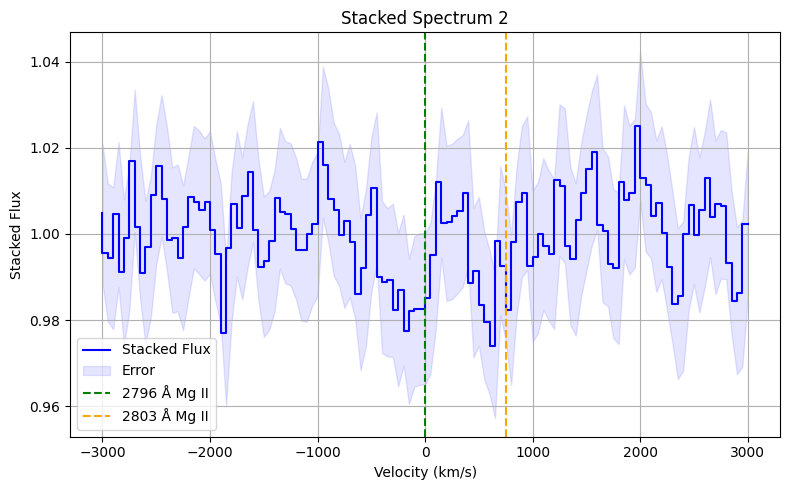

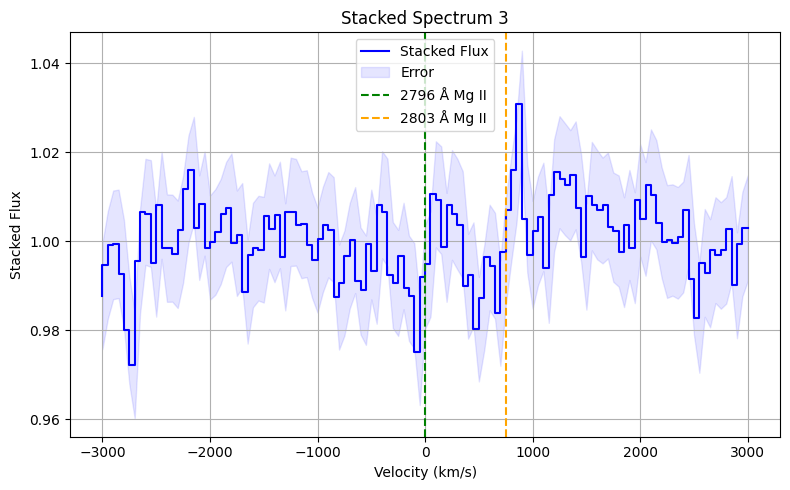

Index	SNR	EW(Å)	±Err	Limit(Å)	Type	Impact(kpc)	Range
1	36.20	0.252	±0.045	0.139	detect	15	0–30
2	56.30	0.065	±0.029	0.090	limit	40	30–50
3	83.33	0.024	±0.020	0.060	limit	100	50–150


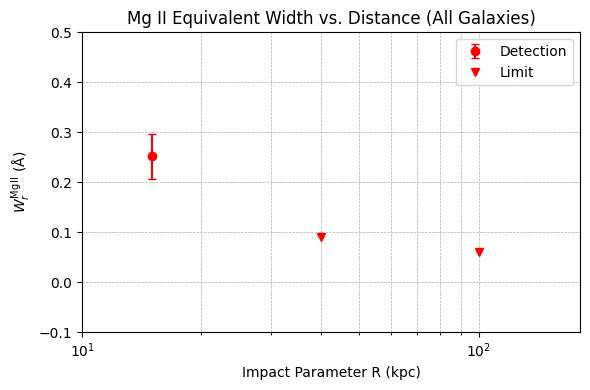

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Constants ---
c = 3e5  # km/s
mg1 = 2796.0  # Mg II λ2796 line center
lambda_0 = mg1
vpix = 50
n_sigma = 3
velocity_range = (-400, 200)
impact_parameters = np.array([15, 40, 100])  # in kpc

# Directories
stacked_dir = "/home/mehak-gupta/mehak/project/UDF_HUDF_sources_FULL /bg_sources/medfilt_cont/velocity/stacked/"
pic_dir = "/home/mehak-gupta/mehak/project/report/pics/final/"
os.makedirs(pic_dir, exist_ok=True)

# Storage
results = []
impact_bins = ["0–30", "30–50", "50–150"]

for i in range(1, 4):
    file_path = os.path.join(stacked_dir, f"median_stacked_spectrum{i}.txt")
    data = np.loadtxt(file_path, skiprows=1)
    velocity, stacked_flux, stacked_error = data[:, 0], data[:, 1], data[:, 2]

    # Plot spectrum
    plt.figure(figsize=(8, 5))
    plt.step(velocity, stacked_flux, color='blue', label="Stacked Flux")
    plt.fill_between(velocity, stacked_flux - stacked_error, stacked_flux + stacked_error,
                     color='blue', alpha=0.1, label="Error")
    plt.axvline(x=0, color='green', lw=1.5, linestyle="--", label="2796 Å Mg II")
    plt.axvline(x=751, color='orange', lw=1.5, linestyle="--", label="2803 Å Mg II")
    plt.xlabel("Velocity (km/s)")
    plt.ylabel("Stacked Flux")
    plt.title(f"Stacked Spectrum {i}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # SNR and EW calculations
    mask = (velocity >= velocity_range[0]) & (velocity <= velocity_range[1])
    v = velocity[mask]
    f = stacked_flux[mask]
    err = stacked_error[mask]

    snr = np.median(f / err)

    # Integrated EW (in velocity space)
    ew_vel = np.trapz(1 - f, v)
    ew_ang = ew_vel * lambda_0 / c  # convert to Angstrom

    # Propagated error on EW
    delta_v = v[1] - v[0]
    ew_err_vel = np.sqrt(np.sum(err**2)) * delta_v
    ew_err_ang = ew_err_vel * lambda_0 / c

    # EW limit calculation
    npix = len(v)
    wr_limit = n_sigma * lambda_0 * vpix * np.sqrt(npix) / (snr * c)

    # Detection check
    if ew_ang > wr_limit:
        detection = "detect"
        plot_val = ew_ang
        plot_err = ew_err_ang
        marker = 'o'
        color = 'red'
    else:
        detection = "limit"
        plot_val = wr_limit
        plot_err = 0
        marker = 'v'
        color = 'red'

    results.append({
        "index": i,
        "snr": snr,
        "ew_ang": ew_ang,
        "ew_err": ew_err_ang,
        "ew_limit": wr_limit,
        "detection": detection,
        "impact": impact_parameters[i-1],
        "range": impact_bins[i-1],
        "marker": marker,
        "color": color,
        "plot_val": plot_val,
        "plot_err": plot_err
    })

# --- Table Output ---
print("Index\tSNR\tEW(Å)\t±Err\tLimit(Å)\tType\tImpact(kpc)\tRange")
for r in results:
    print(f"{r['index']}\t{r['snr']:.2f}\t{r['ew_ang']:.3f}\t±{r['ew_err']:.3f}\t"
          f"{r['ew_limit']:.3f}\t{r['detection']}\t{r['impact']}\t{r['range']}")

# --- Plot ---
plt.figure(figsize=(6, 4))
for r in results:
    plt.errorbar(r["impact"], r["plot_val"], yerr=r["plot_err"] if r["detection"] == "detect" else None,
                 fmt=r["marker"], color=r["color"],
                 label="Detection" if r["detection"] == "detect" else "Limit",
                 markersize=6, capsize=3)

# Deduplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.xscale('log')
plt.xlabel('Impact Parameter R (kpc)')
plt.ylabel(r'$W_r^{\mathrm{Mg\,II}}$ (Å)')
plt.title('Mg II Equivalent Width vs. Distance (All Galaxies)')
plt.xlim(10, 180)
plt.ylim(-0.1, 0.5)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
#plt.savefig(os.path.join(pic_dir, "Eq_width4.png"), dpi=300, bbox_inches="tight")
plt.show()
